In [1]:
#--- import some necessary librairies

import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from scipy.special import boxcox1p,inv_boxcox1p
from scipy.stats import boxcox_normmax,boxcox

from subprocess import check_output
from sklearn.externals import joblib

In [2]:
train = pd.read_csv("/Users/chloe/Google Drive/Kaggle_Data/kaggle_house_price/train.csv")
test = pd.read_csv("/Users/chloe/Google Drive/Kaggle_Data/kaggle_house_price/test.csv")

In [3]:
#--- check the size of the data and drop building_id
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print("The train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 
The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


In [4]:
sales_price = train["SalePrice"]
del train["SalePrice"]
all_data = pd.concat([train, test])

### Deal with missing value

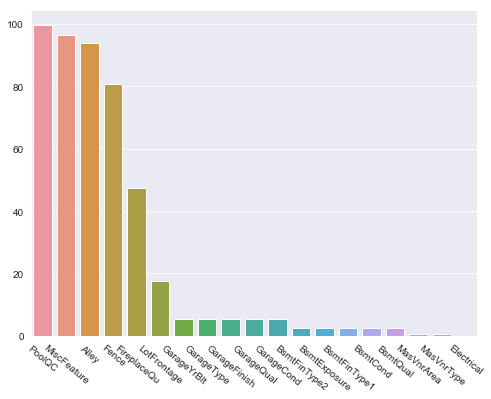

In [5]:
# fill in missing value

train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False) # drop those no na
len(train_na)

f, ax = plt.subplots(figsize=(8, 6))
plt.xticks(rotation='-40')
sns.barplot(x=train_na.index, y=train_na)
plt.show()

In [6]:
all_data["LotFrontage"] = all_data["LotFrontage"].fillna(0)
all_data["has_garage"] = np.where(pd.notnull(all_data["GarageType"]),1,0)
all_data["has_alley"] = np.where(pd.notnull(all_data["Alley"]),1,0)
all_data["has_basement"] = np.where(pd.notnull(all_data["BsmtCond"]), 1, 0)
del all_data["MiscFeature"], all_data["Alley"], all_data["GarageYrBlt"]

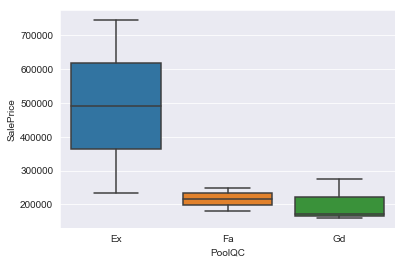

In [7]:
# PoolQC -> different pool quality have huge impact on salesprice -> need to turn it into numerical one
train["SalePrice"] = sales_price
sns.boxplot(x=train["PoolQC"], y=train["SalePrice"])

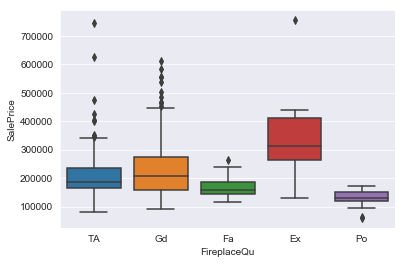

In [8]:
sns.boxplot(x=train["FireplaceQu"], y=train["SalePrice"])

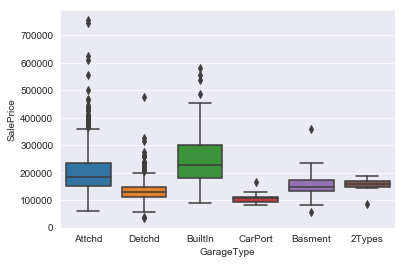

In [9]:
sns.boxplot(x=train["GarageType"], y=train["SalePrice"])

In [10]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("NA")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("NA")
all_data["GarageType"] = all_data["GarageType"].fillna("NA")
all_data["BsmtCond"] = all_data["BsmtCond"].fillna("NA")
all_data["BsmtQual"] = all_data["BsmtQual"].fillna("NA")
all_data["BsmtExposure"] = all_data["BsmtExposure"].fillna("NA")
all_data["GarageCond"] = all_data["GarageCond"].fillna("NA")
all_data["BsmtFinType1"] = all_data["BsmtFinType1"].fillna("NA")
all_data["BsmtFinType2"] = all_data["BsmtFinType2"].fillna("NA")

In [11]:
all_data["has_pool"] = np.where(all_data["PoolArea"]>0, 1, 0)
del all_data["PoolArea"]

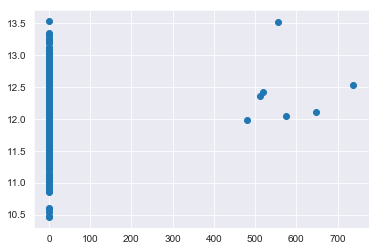

In [12]:
plt.scatter(train["PoolArea"], np.log1p(train["SalePrice"]))
plt.show();

In [13]:
label_encode_col = ["PoolQC", "FireplaceQu", "GarageType", "BsmtCond", "BsmtQual", "BsmtExposure", "GarageCond", "BsmtFinType1", "BsmtFinType2"]
for col in label_encode_col:
    all_data[col] = all_data[col].astype("category")
    all_data[col] = all_data[col].cat.codes

In [14]:
all_data = all_data.dropna(axis=1, how='all')

### Modelling

In [21]:
train = all_data[:len(train)]
test = all_data[len(train):]

In [24]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
#from mlxtend.classifier import StackingClassifier
from sklearn.svm import SVR

In [25]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [26]:
X_train, X_valid, train_y, valid_y = train_test_split(train, np.log1p(sales_price), test_size=0.1, random_state= 0)

In [ ]:
gbm = lgb.LGBMRegressor(objective='regression',
                        metric='mape',
                        num_leaves=80,
                        learning_rate=0.03,
                        n_estimators=6769,
                       colsample_bytree = 0.6886781648348815,
                       max_depth = 18,
                       subsample = 0.7241144257909466)